# HW 10 CLUSTERING BUSINESS

In [1]:
import os
import pandas as pd
import geopandas as gpd
import zipfile 
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
import numpy as np
from scipy.spatial.distance import cdist, pdist
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#!for ((y=93; y<=99; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp$y\totals.zip; done
for y in range(1993,2016):
    filename = 'zbp'+str(y)[2:]+'totals.zip'

    if y <= 2001:
        os.system('wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/' + filename)
    else: 
        os.system('wget ftp://ftp.census.gov/econ' + str(y) + '/CBP_CSV/' + filename)
    print filename
    os.system('mv '+filename + ' ' + os.getenv("PUIDATA") + '/ecoCensus/')

NOTES: 
to read in a zip file without unzipping it you can use the pandas and zipfile packages

In [2]:
filename = 'nyc-zip-code-tabulation-areas-polygons.geojson'

In [ ]:
#ZIPCODES

url = 'https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/HW11_fb55/'
filename = 'nyc-zip-code-tabulation-areas-polygons.geojson'
os.system('wget '+ url + filename)

os.system('mv ' + filename + ' ' + os.getenv("PUIDATA"))

In [3]:
zipcodes = gpd.read_file(os.getenv("PUIDATA") +'/' + filename)
zipcodes = zipcodes.loc[:,['OBJECTID','PO_NAME','borough','geometry','postalCode']]
zipcodes.postalCode = zipcodes.postalCode.astype(int)

In [4]:
zipcodes.head()

,OBJECTID,PO_NAME,borough,geometry,postalCode
0,1,Jackson Heights,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,2,Glen Oaks,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,3,New Hyde Park,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040
3,4,Bellerose,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426
4,5,Fresh Meadows,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365


In [5]:
zipcodes.isnull().sum()

OBJECTID      0
PO_NAME       0
borough       0
geometry      0
postalCode    0
dtype: int64

In [6]:
f = []
for (dirpath, dirnames, filenames) in os.walk(os.getenv("PUIDATA") +'/ecoCensus/'):
    f.extend(filenames)
    break
f.sort()

In [7]:
years = range(2000,2015) + range(1994,2000)

In [8]:
mergeData = zipcodes.copy()
for i in range(len(f)):
    filename = f[i]
    zf = zipfile.ZipFile(os.getenv("PUIDATA") +'/ecoCensus/' + filename)
    df = pd.read_csv(zf.open(filename.replace('.zip','.txt')))
    #change this to upper case later
    try:
        df = df.loc[:,['ZIP','EST']]
    except KeyError:
        df = df.loc[:,['zip','est']]

    df.columns = ['postalCode',str(years[i])]
    #mergeData = zipcodes.copy()
    mergeData = pd.merge(left=mergeData,right=df,on = 'postalCode',how='left')
mergeData.loc[1:10,'2004':'1999']

,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,1994,1995,1996,1997,1998,1999
1,226.0,225.0,226.0,238.0,227.0,233.0,229.0,222.0,241.0,241.0,250.0,194.0,188.0,176.0,192.0,194.0,186.0
2,1406.0,1441.0,1454.0,1488.0,1503.0,1475.0,1494.0,1488.0,1510.0,1539.0,1534.0,1422.0,1414.0,1335.0,1344.0,1344.0,1350.0
3,221.0,226.0,226.0,228.0,226.0,237.0,248.0,256.0,266.0,258.0,260.0,326.0,219.0,209.0,198.0,203.0,217.0
4,599.0,604.0,608.0,617.0,616.0,628.0,643.0,677.0,679.0,714.0,731.0,492.0,476.0,483.0,522.0,509.0,519.0
5,1418.0,1434.0,1442.0,1416.0,1460.0,1450.0,1498.0,1523.0,1554.0,1640.0,1650.0,1147.0,1172.0,1161.0,1189.0,1248.0,1242.0
6,670.0,685.0,690.0,681.0,682.0,681.0,690.0,714.0,714.0,718.0,723.0,669.0,669.0,656.0,641.0,644.0,635.0
7,2010.0,2057.0,2046.0,2064.0,2034.0,2052.0,2060.0,2102.0,2078.0,2124.0,2110.0,1868.0,1925.0,1957.0,1926.0,1949.0,1975.0
8,224.0,230.0,223.0,220.0,222.0,219.0,237.0,248.0,245.0,259.0,276.0,170.0,172.0,176.0,187.0,192.0,203.0
9,1051.0,1093.0,1086.0,1072.0,1057.0,1086.0,1089.0,1108.0,1081.0,1119.0,1118.0,830.0,831.0,839.0,833.0,869.0,897.0
10,367.0,381.0,393.0,403.0,409.0,430.0,449.0,432.0,453.0,467.0,461.0,329.0,328.0,347.0,372.0,363.0,369.0


In [9]:
#normalizing variables
def normalizeCol(column):
    return (column - column.mean())/column.std()

In [10]:
for col in mergeData.columns[4:]:
    mergeData[col] = (mergeData[col] - mergeData[col].mean())/mergeData[col].std()


In [11]:
yearsText = years
yearsText.sort()
yearsText = map(lambda x: str(x), yearsText)

In [12]:
mergeData.loc[:,yearsText].head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,0.422162,0.393028,0.434737,0.423554,0.444907,0.451480,0.471514,0.469081,0.521493,0.561853,...,0.554700,0.540611,0.560404,0.541012,0.572868,0.612109,0.611617,0.648456,0.656257,0.642306
1,-0.496357,-0.511132,-0.526692,-0.518657,-0.522077,-0.541035,-0.532297,-0.517923,-0.532179,-0.528425,...,-0.531069,-0.529154,-0.529543,-0.552121,-0.558042,-0.569638,-0.585378,-0.582832,-0.591993,-0.594923
2,0.593441,0.546598,0.471782,0.453077,0.439057,0.429795,0.422969,0.414156,0.466659,0.462353,...,0.473722,0.480586,0.512870,0.511828,0.490942,0.498155,0.478058,0.470779,0.475351,0.451587
3,-0.379212,-0.484387,-0.498263,-0.513596,-0.514555,-0.515179,-0.512550,-0.507266,-0.538085,-0.542760,...,-0.530243,-0.529154,-0.537882,-0.552955,-0.554664,-0.553600,-0.556818,-0.562075,-0.578014,-0.586772
4,-0.231894,-0.262660,-0.262213,-0.240296,-0.258810,-0.263297,-0.232799,-0.214608,-0.228479,-0.229927,...,-0.217898,-0.215049,-0.213483,-0.227767,-0.224428,-0.220178,-0.203180,-0.219174,-0.203046,-0.202889


In [13]:
X = np.matrix(mergeData.loc[:,yearsText])
X = np.where(np.isnan(X),0,X)


In [14]:
X.shape

(262, 21)

In [15]:
maxK = 10

for n_clusters in range(2,maxK):
    #run the clustering
    km = KMeans(n_clusters=n_clusters, random_state=123)
    #assign labels of clusters
    cluster_labels = km.fit_predict(X)
    #calculate average for each cluster
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.835085874879
For n_clusters =3, the average silhouette_score is :0.653209200593
For n_clusters =4, the average silhouette_score is :0.548111271956
For n_clusters =5, the average silhouette_score is :0.546523810252
For n_clusters =6, the average silhouette_score is :0.540052548481
For n_clusters =7, the average silhouette_score is :0.505706455161
For n_clusters =8, the average silhouette_score is :0.499488073956
For n_clusters =9, the average silhouette_score is :0.4877869135


In [16]:
def elbow(data,K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    plt.title('Elbow for KMeans clustering')
    plt.show()

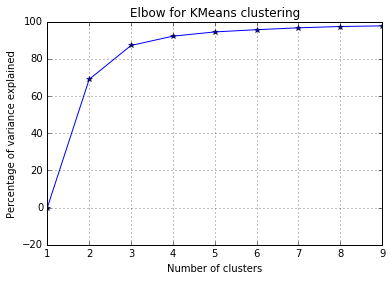

In [17]:
elbow(X, range(1,10))

## Figure 1
The plot shows the percentage of variance explained by que amount of clusters. While 2 clusters explain almost 70 % of variance, with 4 clusters we can achieve over 90%.

In [22]:

#train the model.
km2=KMeans(random_state=324,n_clusters=2)
res2=km2.fit(X)
km4=KMeans(random_state=324,n_clusters=4)
res4=km4.fit(X)

mergeData['k2'] = res2.labels_ 
mergeData['k4'] = res4.labels_ 

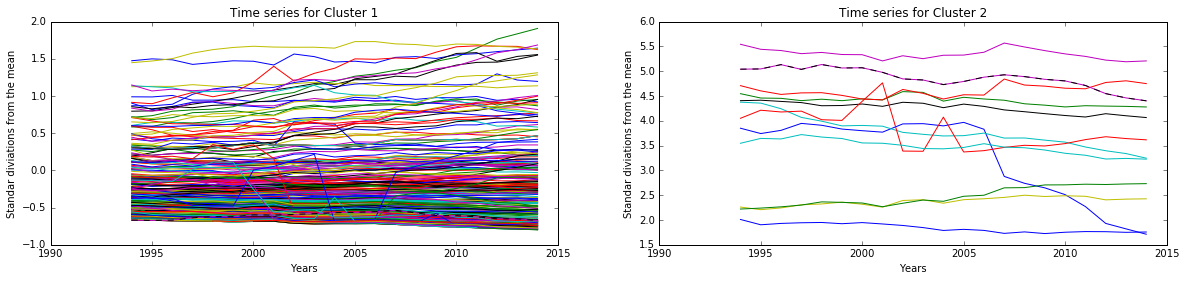

In [51]:
zipsCluster0 = mergeData.loc[mergeData.k2==0].index
zipsCluster1 = mergeData.loc[mergeData.k2==1].index

fig = plt.figure(figsize=(20,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

for i in zipsCluster0:
    ax1.plot(mergeData.loc[i,yearsText])

ax1.plot(yearsText,[mergeData.loc[i,yearsText[j]] for j in range(len(yearsText))],'k--')  
ax1.set_title('Time series for Cluster 1')
ax1.set_xlabel('Years')
ax1.set_ylabel('Standar diviations from the mean')

for i in zipsCluster1:
    ax2.plot(mergeData.loc[i,yearsText])

ax2.plot(yearsText,[mergeData.loc[i,yearsText[j]] for j in range(len(yearsText))],'k--')
ax2.set_title('Time series for Cluster 2')
ax2.set_xlabel('Years')
ax2.set_ylabel('Standar diviations from the mean')



## Figure 2
The plot show the time series for the deviation from the mean for the zipcodes in each cluster. The first cluster's plot show that the amount of business in this cluster is concentrated around one half the mean, plus or minus 1 standar deviation from it. The second cluster shows some zipcodes with more business. We clustered based on the deviation from the mean in the amount of business in a given year. Therefore, zipcodes in the same cluster means that they are similar to each other in this terms. That means that every year they kept the same relative position in terms of amount of business.

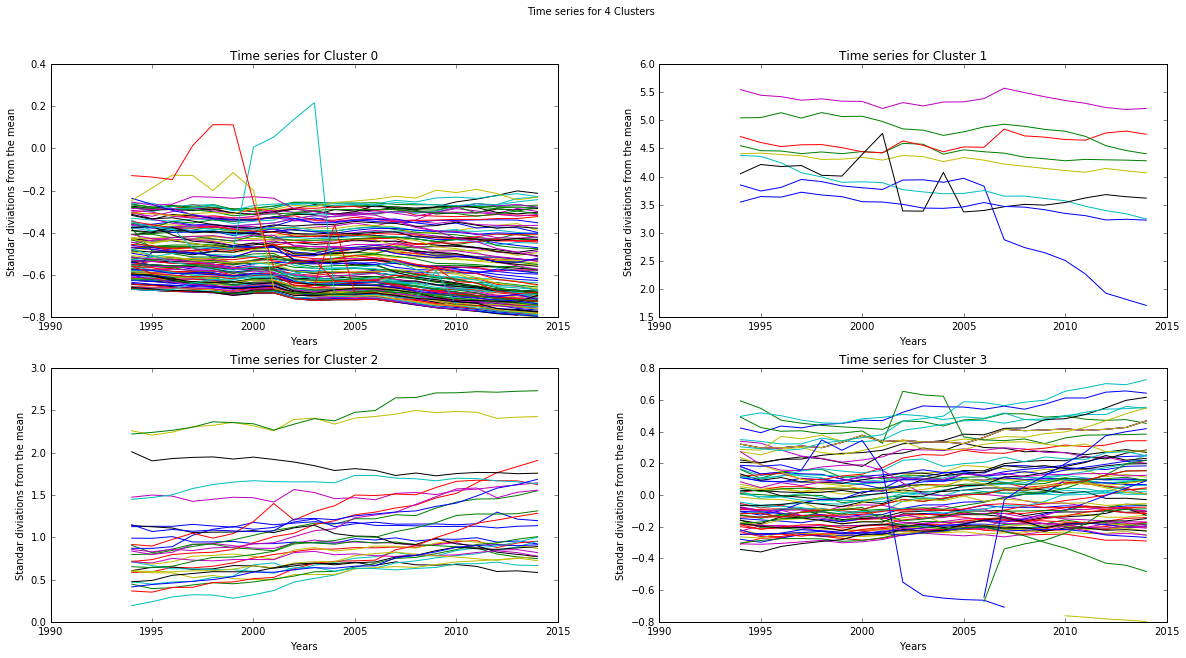

In [53]:
fig = plt.figure(figsize=(20,10))
for cluster in range(0,4):
    ax = fig.add_subplot(2,2,cluster + 1)
    [ax.plot(mergeData.loc[i,yearsText]) for i in mergeData.loc[mergeData.k4==cluster].index]
    ax.set_title('Time series for Cluster ' + str(cluster))
    ax.set_xlabel('Years')
    ax.set_ylabel('Standar diviations from the mean')

    
plt.suptitle('Time series for 4 Clusters')

## Figure 3

Using 4 plots doesn't add new information to the analysis. Two big clusters for the zipcodes with values close to the mean (one wiht lower values) and 2 more clusters to the zipcodes with an amount of bussines higher than the mean (one of them much more higher).

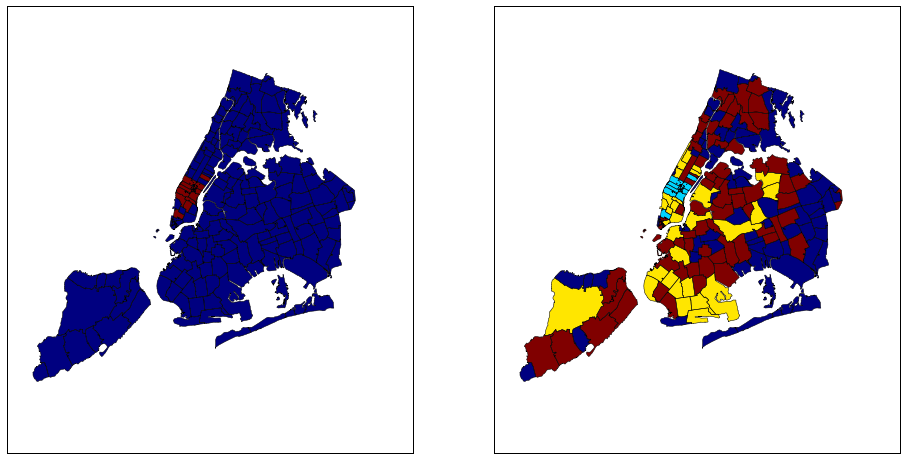

In [21]:
fig = plt.figure(figsize=(16,8)) 
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

mergeData.plot(column = 'k2', alpha=1,linewidth=0.5,ax=ax1)
mergeData.plot(column = 'k4', alpha=1,linewidth=0.5,ax=ax2)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)


## Figure 4
Map with NYC zipcodes colored accordingly to the cluster (with 2 and 4 clusters).  If we use 2 clusters, we should come with one group of zipcodes which has, in a consisten way across time, higher values than the mean. In the other hand, the other we would have zipcodes consistently below the mean in terms of amount of business. In red, the Midtown area shows the zipcodes with higher amount of business. 

If we use more clusters, we could come up with zipcodes with high or low amount of bussines, but each of this groups being subdivided as well into lower an higher. With 4 clusters, Midtown is still the area with the higest amount of business, followed by the yellow areas in Downtown, Upper West Side, Upper East Side and Brooklyn. The blue zipcodes are the ones with lowest amount of business.